# Correcting bit flips

We use the reconstruction of the data to correct bit flips on the buffer timestamp

In [1]:
# import libraries
import raadpy as rp
import matplotlib.pyplot as plt
import os
import numpy as np
from tqdm.notebook import tqdm

# Define some constants
# raw_dir = '../../Data/RAW/'
SD      = '2022-09-15'
raw_dir = '../../Data/Light-1/light1-'+SD+'/'

# Get the subfiles and put the in a dictionary
fnames      = os.listdir(raw_dir)
filenames   = {}
for i in range(1,10): 
    res = [name for name in fnames if f'buff{i}' in name]
    if len(res)>0: filenames[f'buff{i}'] = res[0]

%matplotlib widget

In [2]:
# Load some data
# Directory of the buffer
buffer_fname    = raw_dir + filenames['buff5']

# Decode the buffer data in a dictionary
data            = rp.get_dict(buffer_fname,struct=rp.NONVETO_STRUCT,STUPID=True,VERIFY=True,threshold=3000*1e3,MAX=200000)#,condition=f"data['stimestamp'] <= {5e6}")

Line:   0%|          | 0/200000 [00:00<?, ?it/s]

In [3]:
# Split the data to channels
channels, cnt = rp.split_channels(data,rp.NONVETO_STRUCT)

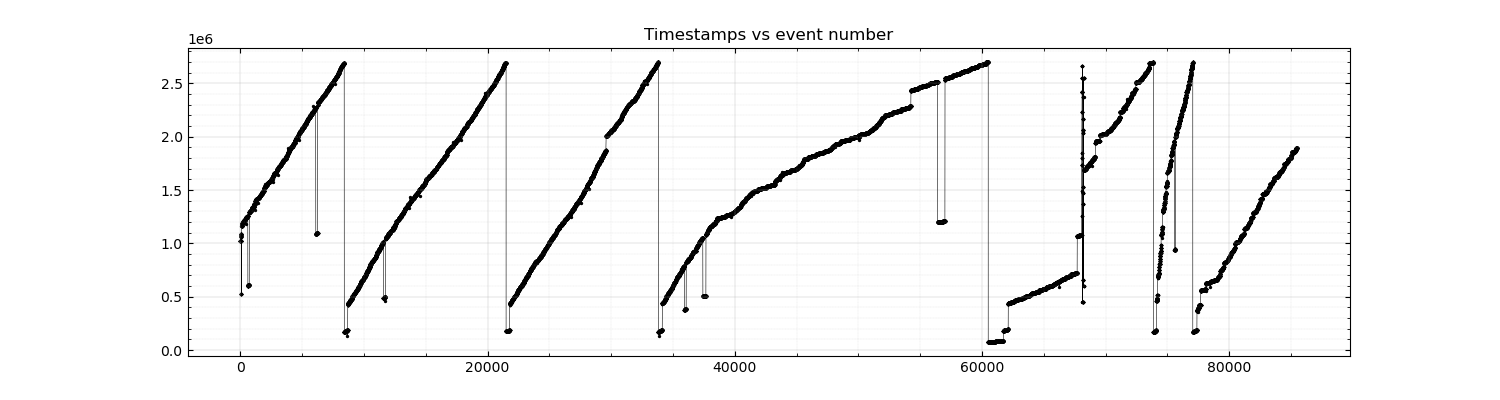

In [4]:
# Plot some data
rp.plot_timestamp(channels[0]);


In [5]:
# Plot the differences
timestamp           = channels[0]['stimestamp'].copy()
timestamp_deltas    = timestamp[1:] - timestamp[:-1]

In [6]:
# Get the most significant bit of number
def get_msb(x:int,BITS=48):
    for i in range(BITS):
        x |= x >> int(2**i)
    return (x+1) >> 1

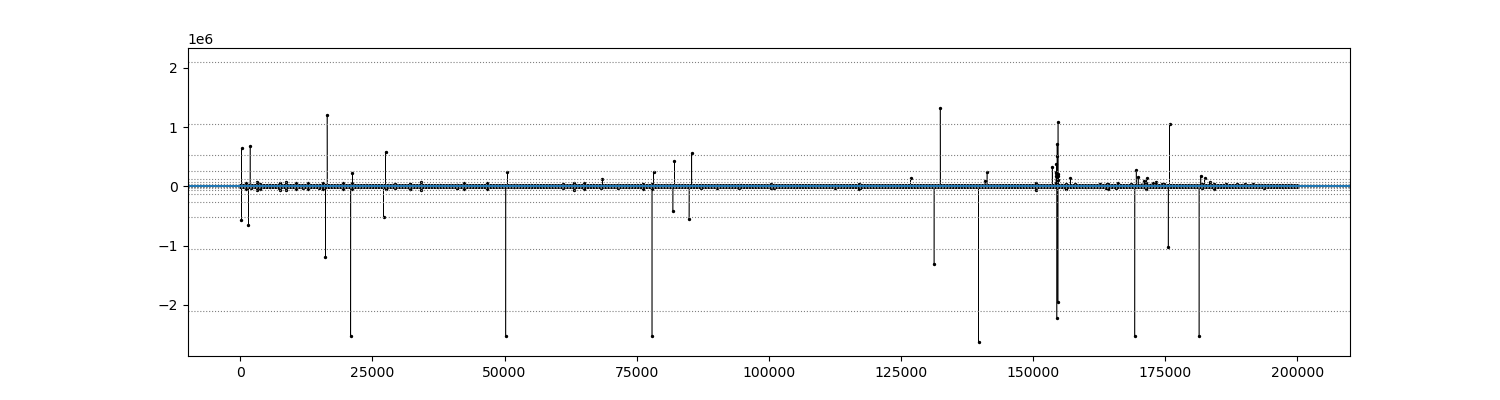

In [7]:
MAXBIT = 22

# Plot it
fig = plt.figure(figsize=(15,4),dpi=100)
ax  = fig.add_subplot(111)

# Plot a line and dots
ax.plot(cnt[0][:-1],timestamp_deltas,c='k',lw=0.4)
ax.scatter(cnt[0][:-1],timestamp_deltas,c='k',marker='o',s=2)

# Plot all the bits lines
for i in range(min(rp.NONVETO_STRUCT['stimestamp'],MAXBIT)):
    ax.axhline(int(1<<i),c='grey',ls=':',lw=0.8)
    ax.axhline(-int(1<<i),c='grey',ls=':',lw=0.8)

ax.axhline(np.mean(2*abs(timestamp_deltas)))

In [23]:
# Run a rudementary correction
# Remove most significant bit of values above a certain threshold
MEAN = np.mean(abs(timestamp_deltas))

# Recursively keep removing the Most Significant Bit, until you're below the mean threshold
def correct(x,MEAN,BITS=48):
    if abs(x) <= MEAN: 
        return x
    if x > 0: return correct(x - get_msb(x,BITS),MEAN,BITS)
    else: return correct(x + get_msb(abs(x),BITS),MEAN,BITS)

# Find pairs
def find_pairs(diffs,MEAN):
    candidates  = np.array([])
    idxs        = np.array([],dtype=int)

    pairs = []    
    for i,d in enumerate(diffs):
        # If this is a candidate for a thing 
        if abs(d) > MEAN: 
            candidates = np.append(candidates,[d])
            idxs       = np.append(idxs      ,[i])
        
        if len(candidates) > 0:
            candidates += d
            idx = np.where(abs(candidates) < np.sqrt(MEAN))[0]
            if len(idx) > 0:
                index = np.argmin(candidates[idx])
                pairs.append((idxs[index],i))
                candidates = np.delete(candidates,[index,int(-1)],axis=0)
                idxs       = np.delete(idxs      ,[index,int(-1)],axis=0)

    return np.array(pairs)

# corrected_deltas = np.array([correct(int(t),rp.NONVETO_STRUCT['stimestamp']) for t in tqdm(timestamp_deltas)])
pairs = find_pairs(timestamp_deltas,MEAN)

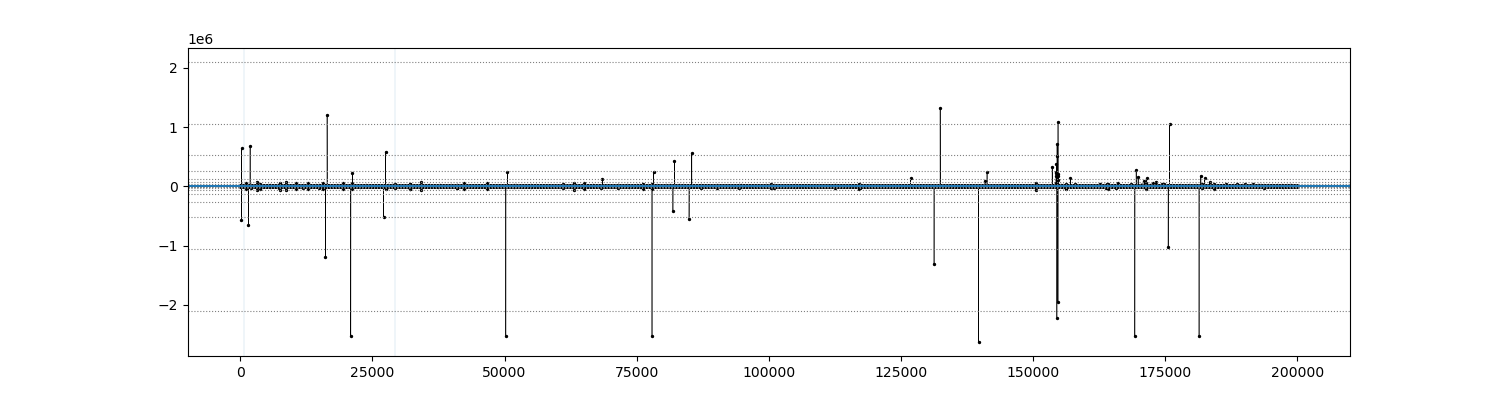

In [38]:
MAXBIT = 22

# Plot it
fig = plt.figure(figsize=(15,4),dpi=100)
ax  = fig.add_subplot(111)

# Plot a line and dots
ax.plot(cnt[0][:-1],timestamp_deltas,c='k',lw=0.4)
ax.scatter(cnt[0][:-1],timestamp_deltas,c='k',marker='o',s=2)

pair = pairs[12]
ax.axvline(cnt[0][pair[0]],lw=0.1)
ax.axvline(cnt[0][pair[1]],lw=0.1)

# Plot all the bits lines
for i in range(min(rp.NONVETO_STRUCT['stimestamp'],MAXBIT)):
    ax.axhline(int(1<<i),c='grey',ls=':',lw=0.8)
    ax.axhline(-int(1<<i),c='grey',ls=':',lw=0.8)

ax.axhline(np.mean(2*abs(timestamp_deltas)))

NameError: name 'corrected_deltas' is not defined

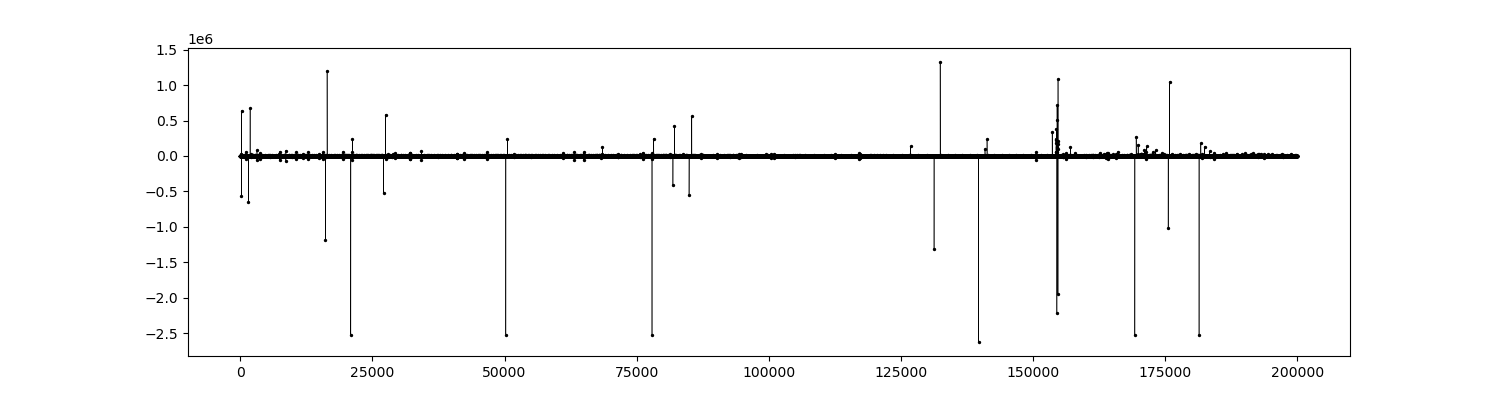

In [11]:
# Plot corrected timestamps
MAXBIT = 22

# Plot it
fig = plt.figure(figsize=(15,4),dpi=100)
ax  = fig.add_subplot(111)

# Plot a line and dots
ax.plot(cnt[0][:-1],timestamp_deltas,c='k',lw=0.4)
ax.scatter(cnt[0][:-1],timestamp_deltas,c='k',marker='o',s=2)

ax.plot(cnt[0][:-1],corrected_deltas,c='r',lw=0.4)
ax.scatter(cnt[0][:-1],corrected_deltas,c='r',marker='o',s=2)

# Plot all the bits lines
for i in range(min(rp.NONVETO_STRUCT['stimestamp'],MAXBIT)):
    ax.axhline(int(1<<i),c='grey',ls=':',lw=0.8)
    ax.axhline(-int(1<<i),c='grey',ls=':',lw=0.8)

ax.axhline(np.mean(2*abs(timestamp_deltas)))

# Checking likelihood of bit flip

We can check what is the likelihood a difference was caused by a bit flip. We can weight that likelihood based on the significance of the bit. It is more likel

In [39]:
def invert_flips(timestamp,struct=rp.NONVETO_STRUCT,MAX_TIME=2.0e6):
    # Get the gradient of the timestamp
    timestamp_deltas = timestamp[1:] - timestamp[:-1]

    # Get Mean and standard deviation
    MEAN = np.mean(abs(timestamp_deltas))
    STD  = np.std(abs(timestamp_deltas))
    print(MEAN,STD)

    # Identify the big ramps
    ramps = [0] + list(np.where(timestamp_deltas <= -MAX_TIME)[0]) + [len(timestamp) - 1]
    ramps = [(ramps[i]+1,ramps[i+1]) for i in range(len(ramps) - 1)]

    # Go through the correction pass
    # For each ramp
    for ramp in ramps:
        # For every ramp find the flips
        # flips = []
        # for i in range(*ramp):
        #     if abs(i) > MEAN+2*STD:
        ADD = 0
        for i in range(*ramp):
            ADD += correct(int(timestamp_deltas[i]),2*MEAN+0*STD,BITS=struct['stimestamp']) - timestamp_deltas[i]
            timestamp[i+1] += ADD

    return timestamp

times = invert_flips(timestamp.copy())


660.7519504064566 27013.802455747154


(<Figure size 1500x400 with 1 Axes>,
 <AxesSubplot:title={'center':'Timestamps vs event number'}>)

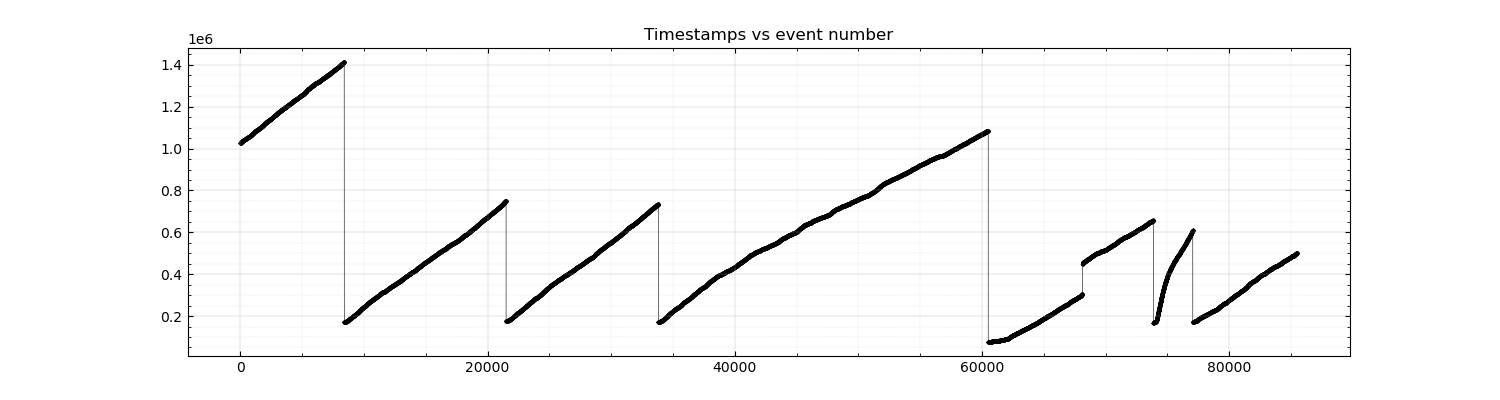

In [45]:
test = channels[0].copy()
test['stimestamp'] = times
rp.plot_timestamp(test)

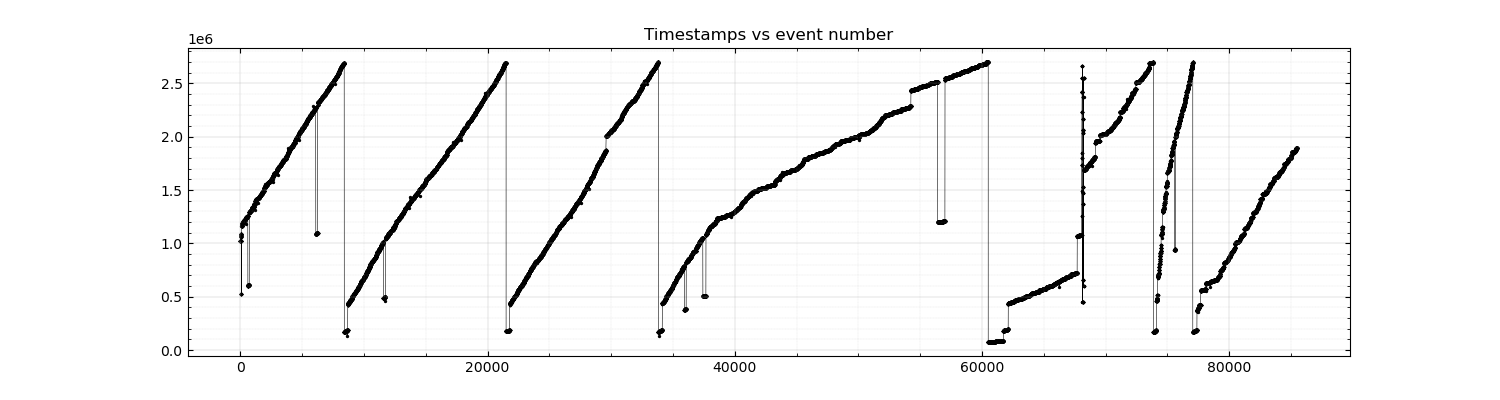

In [41]:
# Plot some data
rp.plot_timestamp(channels[0]);

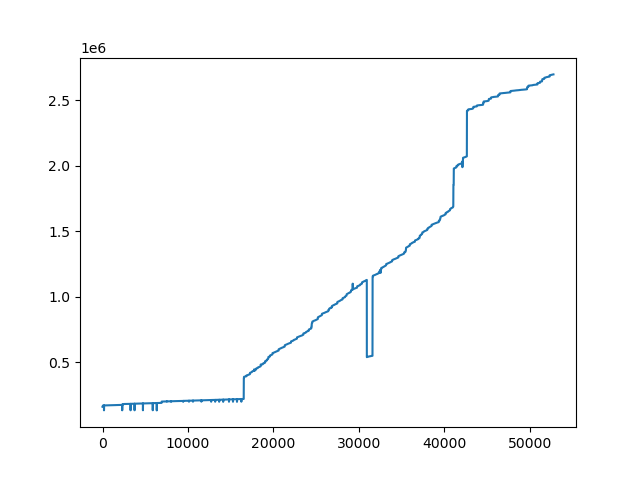

In [ ]:
fig = plt.figure()
plt.plot(timestamp[range(*ramps[9])])

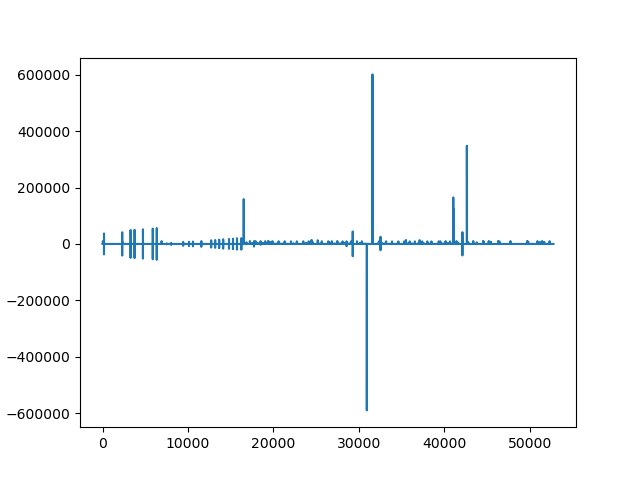

In [ ]:
fig = plt.figure()
plt.plot(timestamp_deltas[range(*ramps[9])])